# 1. Introduction

A Minecraft server set up by a research group in Computer Science at UBC, led by Frank Wood, aims to refine its recruitment efforts such that they can handle the number of players they attract.

The following project discusses the broad question of what player characteristics/behaviours are most predictive of a subscription to the game-related newsletter, and we sought to answer:
>What are the optimal variables and model that optimizes the prediction of the probability of a subscription occurring in the players.csv dataset?

We chose this dataset as it contains the relevant variables such as Age, Hours played, and Experience level.

**About the Data**

Players.csv includes a list of all unique players, including their recorded data:

| Type | Total observations |
| :------------ | :-----------: 
| Observations (rows)  | 196 |
| Variables (columns)   | 7 |


| Variable | Type | Description |
| :------------ | :-----------: | ------------: |
| experience | Chr | User experience level |
| subscribe | Igl  | Subscription |
| hashedEmail | chr | Hashed email identifier |
| played-hours | dbl | Hours played |
| name | chr | Username |
| gender | chr | Gender |
| Age | dbl | Age in years |

**About the Data Collection**

- Players' actions are recorded as they navigate through the world
- Collected more than 10,000 hours of over ten thousand multiplayer Minecraft gameplay
- The project records spoken interactions between players from the player's microphone.
- The "experience" column in the players.csv file was collected on a self-declared basis as users signed up

**Potential Issues with the Data**

- Age range implications - parental consent for players under 13, "The parent can revoke consent any time"
- Geographic ties - individuals who respond are likely UBC students or those who saw promotions
- Access to the study - Individuals who may never get the access link to Plaicraft/never discover the study
- Ability to delete recorded data -"provide us with session ID (found in the email or SMS with your access link) of the game session you would like us to delete. Alternatively, email support@plaicraft.ai for assistance."

# 2. Wrangling

To prepare the data for analysis, we first loaded the `players.csv` and `sessions.csv` files and inspected their structure with `glimpse()`. The players dataset contains demographics, subscription status, and total played hours for each user. Following our project plan, we removed players with `played_hours == 0`, since these users do not provide any behavioural information relevant to predicting subscription. We also excluded rows with missing values in `subscribe` or `played_hours`, and converted the categorical variables (`experience`, `gender`, `subscribe`) into factors. 

The sessions dataset required additional wrangling because its timestamps were stored as character strings. Using `separate()`, we extracted date, hour, and minute components from each start and end time, and computed a new variable `duration_min` to represent each session length. We removed sessions with zero or negative duration, then summarized each user's gameplay by calculating their number of sessions (`n_sessions`) and average session length (`mean_session_min`). These summaries were useful for exploratory analysis but were not included as predictors in the final models, which focused on the variables that performed best during tuning (Age, played_hours, and experience).

After cleaning, we generated summary statistics to understand overall gameplay behavior. The distribution of played hours is highly right-skewed, with most players having less than one hour of total playtime and a small number recording extremely high totals. Boxplots comparing played hours by subscription show that subscribed players tend to have slightly higher engagement on average.

We also examined the balance of the outcome variable(`subscribe`). The majority of players in our dataset are subscribers, which means the data is moderately imbalanced. Understanding this imbalance is important because classification accuracy can be misleading when one class dominates where a model may achieve high accuracy simply by predicting the majority class. This class balance summary provides context for interpreting the performance of both the KNN and logistic regression models.

In [1]:
suppressPackageStartupMessages({library(tidyverse)
library(tidymodels)
library(themis)})
set.seed(1234)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
glimpse(players)
glimpse(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [2]:
# Wrangling - Clean players dataset
players_clean <- players |>
    filter(!is.na(subscribe), !is.na(played_hours), played_hours > 0) |>
    mutate(subscribe = factor(subscribe), gender = factor(gender), experience = factor(experience))
glimpse(players_clean)

Rows: 111
Columns: 7
$ experience   <fct> Pro, Veteran, Amateur, Regular, Amateur, Veteran, Beginne…
$ subscribe    <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRU…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.7, 0.1, 0.1, 1.6, 1.5, 0.2, 48.4, 0.5, 0.6, …
$ name         <chr> "Morgan", "Christian", "Flora", "Kylie", "Natalie", "Lane…
$ gender       <fct> Male, Male, Female, Male, Male, Female, Female, Male, Fem…
$ Age          <dbl> 9, 17, 21, 21, 47, 23, 25, 22, 17, 17, 19, 58, 17, 17, 21…


In [3]:
# Wrangling - Clean sessions dataset
sessions_clean <- sessions |>
    separate(start_time, into = c("start_date", "start_clock"), sep = " ") |>
    separate(end_time, into = c("end_date", "end_clock"), sep = " ") |>
    separate(start_clock, into = c("start_hour", "start_minute"), sep = ":", convert = TRUE) |>
    separate(end_clock, into = c("end_hour", "end_minute"), sep = ":", convert = TRUE) |>
    mutate(duration_min = (end_hour - start_hour) * 60 + (end_minute - start_minute)) |>
    filter(duration_min > 0)
glimpse(sessions_clean)


Rows: 1,441
Columns: 10
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_date          <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ start_hour          <int> 18, 23, 17, 3, 16, 15, 7, 2, 2, 5, 1, 15, 2, 0, 18…
$ start_minute        <int> 12, 33, 34, 22, 1, 8, 12, 13, 31, 13, 31, 15, 32, …
$ end_date            <chr> "30/06/2024", "17/06/2024", "25/07/2024", "25/07/2…
$ end_hour            <int> 18, 23, 17, 3, 16, 17, 7, 2, 2, 5, 1, 15, 3, 3, 18…
$ end_minute          <int> 24, 46, 57, 58, 12, 10, 21, 30, 49, 52, 35, 43, 12…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ duration_min        <dbl> 12, 13, 23, 36, 11, 122, 9, 17, 18, 39, 4, 28, 40,…


In [4]:
# Summarize sessions per player
sessions_summary <- sessions_clean |>
    group_by(hashedEmail) |>
    summarize(n_sessions = n(), mean_session_min = mean(duration_min))
glimpse(sessions_summary)

Rows: 124
Columns: 3
$ hashedEmail      <chr> "0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95…
$ n_sessions       <int> 1, 1, 1, 13, 2, 1, 1, 40, 1, 1, 1, 2, 1, 1, 75, 1, 1,…
$ mean_session_min <dbl> 45.000000, 30.000000, 11.000000, 32.153846, 35.000000…


In [5]:
# Join players + session summaries
players_final <- players_clean |>
    left_join(sessions_summary, by = "hashedEmail")
glimpse(players_final)

Rows: 111
Columns: 9
$ experience       <fct> Pro, Veteran, Amateur, Regular, Amateur, Veteran, Beg…
$ subscribe        <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,…
$ hashedEmail      <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee97…
$ played_hours     <dbl> 30.3, 3.8, 0.7, 0.1, 0.1, 1.6, 1.5, 0.2, 48.4, 0.5, 0…
$ name             <chr> "Morgan", "Christian", "Flora", "Kylie", "Natalie", "…
$ gender           <fct> Male, Male, Female, Male, Male, Female, Female, Male,…
$ Age              <dbl> 9, 17, 21, 21, 47, 23, 25, 22, 17, 17, 19, 58, 17, 17…
$ n_sessions       <int> 22, 3, 1, 1, 1, 3, 1, 1, 32, 2, 2, 1, 1, 2, 1, 1, NA,…
$ mean_session_min <dbl> 58.63636, 85.00000, 50.00000, 9.00000, 13.00000, 38.3…


In [6]:
# Summary stats

# Overall
players_final |>
    summarize(
        mean_hours = mean(played_hours),
        median_hours = median(played_hours),
        sd_hours = sd(played_hours),
        subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by experience
players_final |>
    group_by(experience) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

# Subscription rate by gender
players_final |>
    group_by(gender) |>
    summarize(subscription_rate = mean(subscribe == "TRUE"))

# Class balance
players_final |>
  count(subscribe) |>
  mutate(prop = n / sum(n))

mean_hours,median_hours,sd_hours,subscription_rate
<dbl>,<dbl>,<dbl>,<dbl>
10.32252,0.5,37.1334,0.7747748


experience,subscription_rate
<fct>,<dbl>
Amateur,0.8000000
Beginner,0.7894737
Pro,0.7272727
Regular,0.9000000
Veteran,0.6538462


gender,subscription_rate
<fct>,<dbl>
Agender,1.0000000
Female,0.7619048
Male,0.7733333
Non-binary,0.8333333
Other,1.0000000
Prefer not to say,0.6000000
Two-Spirited,1.0000000


subscribe,n,prop
<fct>,<int>,<dbl>
FALSE,25,0.2252252
TRUE,86,0.7747748


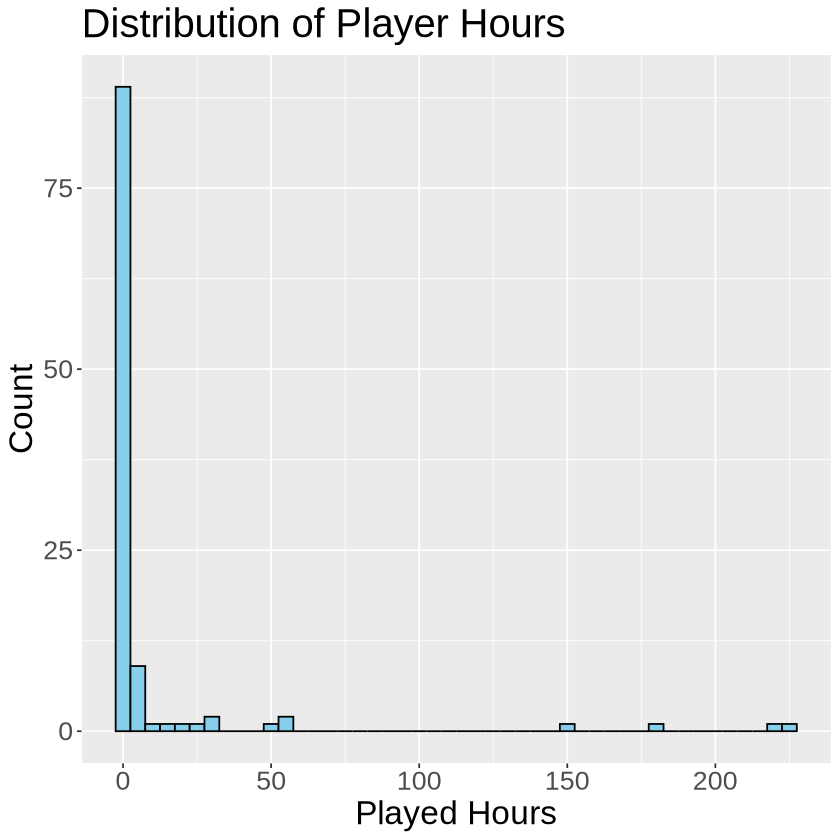

In [7]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 5, fill = "skyblue", color = "black") +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 1.** Distribution of played hours (full scale). This histogram shows that the distribution is extremely right-skewed, which a few players recording very high totals. 

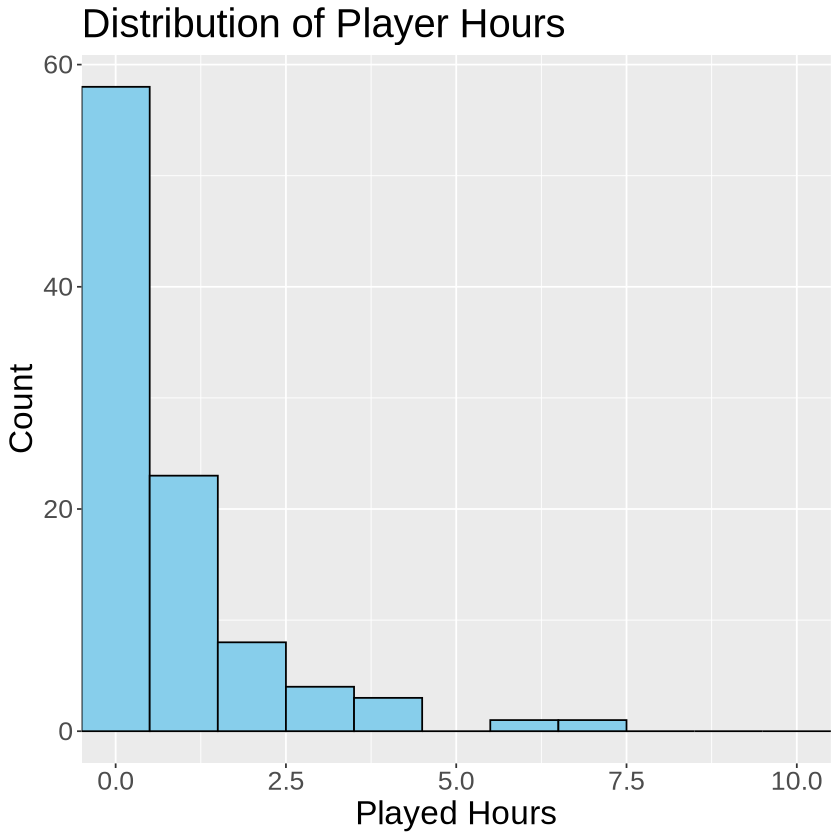

In [8]:
options(repr.plot_height = 20, repr.plot_width = 20)
ggplot(players_final, aes(x = played_hours)) +
    geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
    coord_cartesian(xlim = c(0, 10)) +
    labs(x = "Played Hours", y = "Count", title = "Distribution of Player Hours") +
    theme(text = element_text(size = 20))

**Figure 2.** Distribution of played hours (0-10 hours). Zooming in on the lower range shows that most players have played under two hours. 

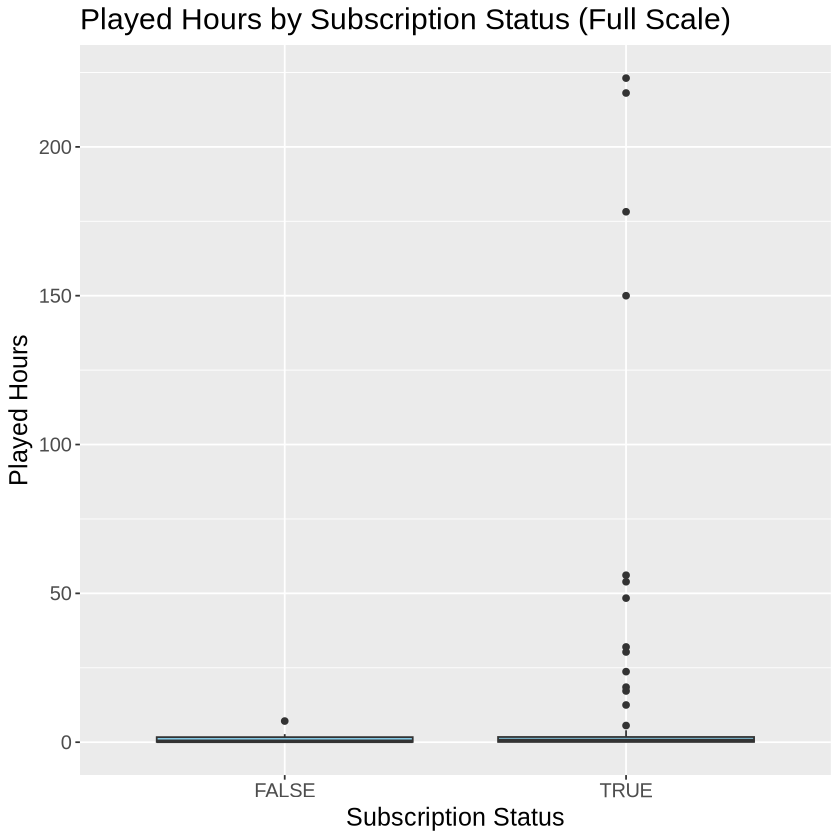

In [9]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Full Scale)") +
    theme(text = element_text(size = 15))

**Figure 3.** Boxplot of played hours by subscription status (full scale). Subscribed players tend to show slightly higher engagement.

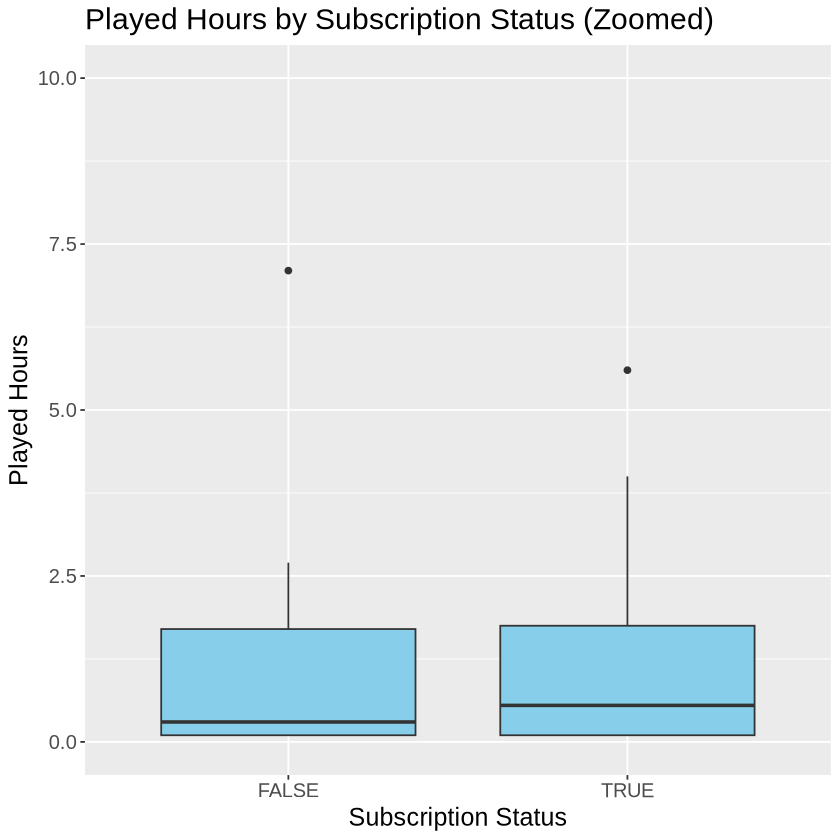

In [10]:
ggplot(players_final, aes(x = subscribe, y = played_hours)) +
    geom_boxplot(fill = "skyblue") +
    coord_cartesian(ylim = c(0, 10)) +
    labs(x = "Subscription Status", y = "Played Hours", title = "Played Hours by Subscription Status (Zoomed)") +
    theme(text = element_text(size = 15))

**Figure 4.** Boxplot of played hours by subscription status, zoomed to 0-10 hours for clarity. This highlights that most players play very little. 

In [11]:
players_final |>
    count(subscribe) |>
    mutate(prop = n / sum(n))

subscribe,n,prop
<fct>,<int>,<dbl>
FALSE,25,0.2252252
TRUE,86,0.7747748


These cleaned and summarized data will be used by the modeling section to fit logistic regression models predicting subscription from gameplay behaviour and demographic variables. 

# 3. Dealing With Visualizations

**Legend of Visualizations:**
| Figure # | Section | Description |
| :------------ | :-----------: | :------------ |
| 1| 2 | Distribution of played hours (full scale) |
| 2 | 2 | Distribution of played hours (0-10 hours) |
| 3| 2 | Boxplot of played hours by subscription status (full scale) |
| 4 | 2 | Boxplot of played hours by subscription status (0-10) hours |
| 5| 4.1 |  Line plot of Mean Accuracy  |
| 6 | 4.1 | Classification outcome scatterplot|
| 6.1 | 4.1 | Density plot of probability - KNN|
| 7 | 4.2 | Density plot of probability - Regression |

# 4.1 Data Analysis - Part 1: Classification Model
Many different approaches to a classification model for newspaper subscriptions are possible. Therefore, there are specific parameters that have been set:
* 70/30 training/testing split
* 5-fold cross-validation
* target: subscribe
* all predictors: experience, age, played_hours

### Methodology
For the first part of making the classification model, the goal was to select the model with predictors that give the highest accuracy. The three predictors from which combinations were made were: `experience`, `age`, and `played_hours`.

To be able to use experience as a predictor, the factors amateur to veteran were converted to a scale of 1 to 5. 

The players dataset was then split into training and testing with a 70:30 train-test split, stratified by the subscriber status. 

After this, recipes were formed for each combination of predictors, in which the data was also standardized. These recipes were used in tuning the number of nearest neighbors, k. Values of k from 2 to 10 and cross-validation with 5 folds, again stratified by subscriber status, were used in the tuning. The classification model was set to work through k-NN. 

For each of the recipes, the highest accuracy produced with 2$\leq$k$\leq$10 were tabulated and arranged in order from largest to smallest. The recipe producing the highest accuracy, which was the recipe including `played_hours` and `age` as predictors, was then plotted as mean accuracy vs each k, as shown in Figure 5. The highest k with the lowest fluctation around it was then identified visually to be k=5. 

Using an adjusted model with the found optimal recipe including `played_hours` and `age` and nearest neighbors k=5, the training model was fit. 

The model was then used to classify the testing data. The accuracy, kap value, and confusion matrix for the model were produced based on this.

The model for classification was then used to also predict the probabilities of subscription.

In [12]:
#Make the experience numerical
players_for_model <- players_final |>
    mutate(experience = as.numeric(factor(experience, levels = c("Amateur", "Beginner", "Regular", "Pro", "Veteran")))) |>
    na.omit()
head(players_for_model)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,n_sessions,mean_session_min
<dbl>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>
4,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,22,58.63636
5,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,85.00000
1,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,50.00000
3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,1,9.00000
1,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47,1,13.00000
5,TRUE,7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,1.6,Lane,Female,23,3,38.33333


In [13]:
set.seed(1234)

#Splitting into training and testing
player_split <- initial_split(players_for_model, prop = .7, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [14]:
#All the recipes:
#played_hours = H, Age = A, experience = E

newspaper_AE_recipe <- recipe(subscribe ~ experience + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 
                        

newspaper_AH_recipe <- recipe(subscribe ~ played_hours + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_HE_recipe <- recipe(subscribe ~ experience + played_hours, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_A_recipe <- recipe(subscribe ~ Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

newspaper_H_recipe <- recipe(subscribe ~ played_hours, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

newspaper_E_recipe <- recipe(subscribe ~ experience, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

#Recipe for all 3 parameters
newspaper_3C3_recipe <- recipe(subscribe ~ experience + played_hours + Age, data = player_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

In [15]:
set.seed(1234)

#TUNING K
train_fold <- vfold_cv(player_training, v=5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 2, to = 10, by = 1))

#Make model for k tuning
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

#initialize tibble
highest_acc_per_recipe = tibble(recipe_name = character(), accuracy = numeric())

tune_k <- function(recipe, recipe_name) {
    #Workflow to get metrics for k tuning
    newspaper_workflow <- workflow() |>
        add_recipe(recipe) |>
        add_model(knn_tune) |>
        tune_grid(resamples = train_fold, grid = k_vals) |>
        collect_metrics()

    #Find the highest accuracy per recipe
    highest_accuracy <- newspaper_workflow |>
        filter(.metric == 'accuracy') |>
        arrange(desc(mean)) |>
        slice(1) |>
        pull(mean)

    #Add to tibble
    highest_acc_per_recipe <<- highest_acc_per_recipe |>
        add_row(recipe_name = recipe_name, accuracy = highest_accuracy)
    
    }

tune_k(newspaper_3C3_recipe, '3C3 Recipe')
tune_k(newspaper_AE_recipe, 'AE Recipe')
tune_k(newspaper_AH_recipe, 'AH Recipe')
tune_k(newspaper_HE_recipe, 'HE Recipe')
tune_k(newspaper_A_recipe, 'A Recipe')
tune_k(newspaper_H_recipe, 'H Recipe')
tune_k(newspaper_E_recipe, 'E Recipe')

ordered_highest_acc_per_recipe <- highest_acc_per_recipe |>
    arrange(desc(accuracy))

ordered_highest_acc_per_recipe

# The highest accuracy is found with Age and Mean Played Hours as predictors

recipe_name,accuracy
<chr>,<dbl>
AH Recipe,0.7859524
3C3 Recipe,0.7609524
AE Recipe,0.7609524
A Recipe,0.7421429
HE Recipe,0.7057143
E Recipe,0.7047619
H Recipe,0.5967857


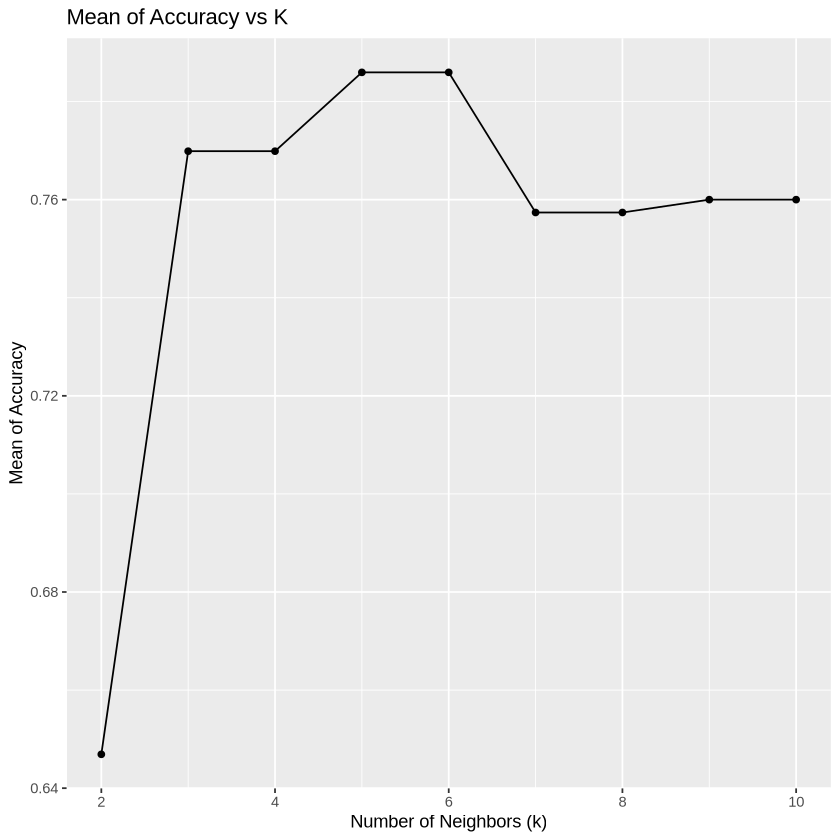

In [16]:
#Tuning k for Age+played_hours as predictors
set.seed(1234)

train_workflow <- workflow() |>
    add_recipe(newspaper_AH_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = train_fold, grid = k_vals) |>
    collect_metrics()

#Make the plot to see which k gives optimal accuracy
cross_val_plot <- train_workflow |>
    filter(.metric == 'accuracy') |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Mean of Accuracy vs K")+
    labs(x = 'Number of Neighbors (k)', y = 'Mean of Accuracy')

cross_val_plot

#plot shows that k=5 gives the highest accuracy (with least fluctutation around it)

**Figure 5.** Line plot of mean accuracy shows that k=5 gives the highest accuracy (with least fluctuation around it).


In [23]:
#Now, using k=5 and newspaper_AH_recipe:
set.seed(1234)

newspaper_AH_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
   

newspaper_AH_fit <- workflow() |>
    add_recipe(newspaper_AH_recipe) |>
    add_model(newspaper_AH_spec) |>
    fit(data = player_training)
newspaper_AH_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2133333
Best kernel: rectangular
Best k: 5

In [18]:
set.seed(1234)

#TESTING

newspaper_predictions <- predict(newspaper_AH_fit, player_testing) |>
    bind_cols(player_testing)
# newspaper_predictions

newspaper_metrics <- metrics(newspaper_predictions, truth = subscribe, estimate = .pred_class)
newspaper_metrics

newspaper_conf_mat <- conf_mat(newspaper_predictions, truth = subscribe, estimate = .pred_class)
newspaper_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7272727
kap,binary,-0.0569395


          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE      8   24

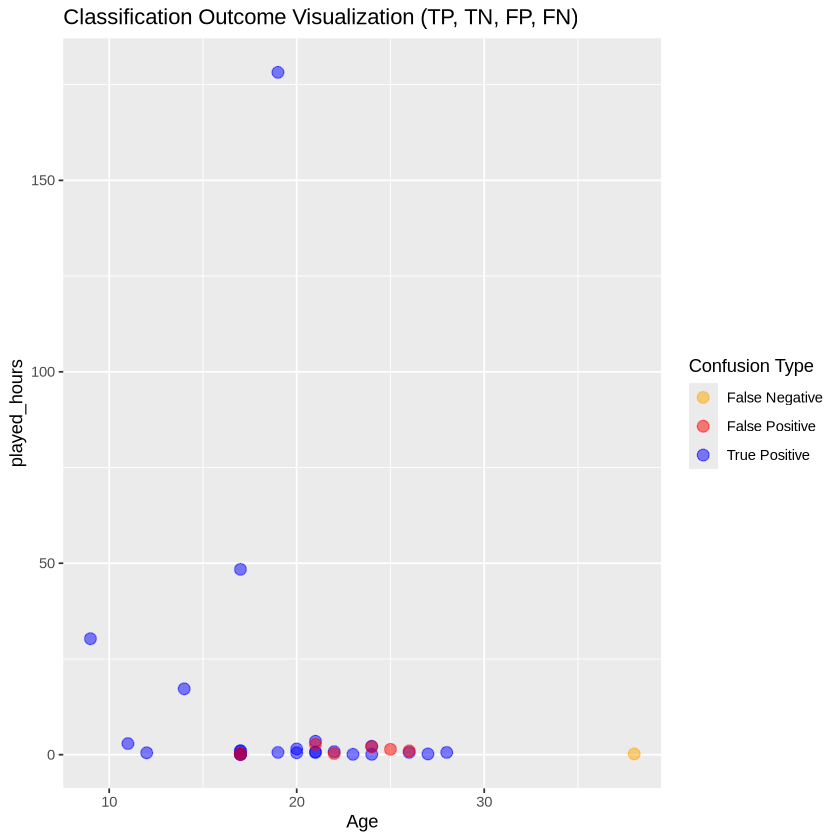

In [19]:
newspaper_predictions <- newspaper_predictions |>
  mutate(conf_type = case_when(
      subscribe == TRUE  & .pred_class == TRUE  ~ "True Positive",
      subscribe == FALSE & .pred_class == FALSE ~ "True Negative",
      subscribe == FALSE & .pred_class == TRUE  ~ "False Positive",
      subscribe == TRUE  & .pred_class == FALSE ~ "False Negative"))

knn_sp<-ggplot(newspaper_predictions, aes(x = Age, y = played_hours)) +
  geom_point(aes(color = conf_type), size = 3 , alpha = 0.5) +
  scale_color_manual(values = c(
    "True Positive" = "blue",
    "True Negative" = "green",
    "False Positive" = "red",
    "False Negative" = "orange")) +
  labs(title = "Classification Outcome Visualization (TP, TN, FP, FN)",
    color = "Confusion Type")
knn_sp

**Figure 6.** Scatterplot of knn classification outcomes helps us understand the confusion matrix. We can clearly see areas where FP overlaps TP (where the classification is not successful) and potential outliers or noisy points. 

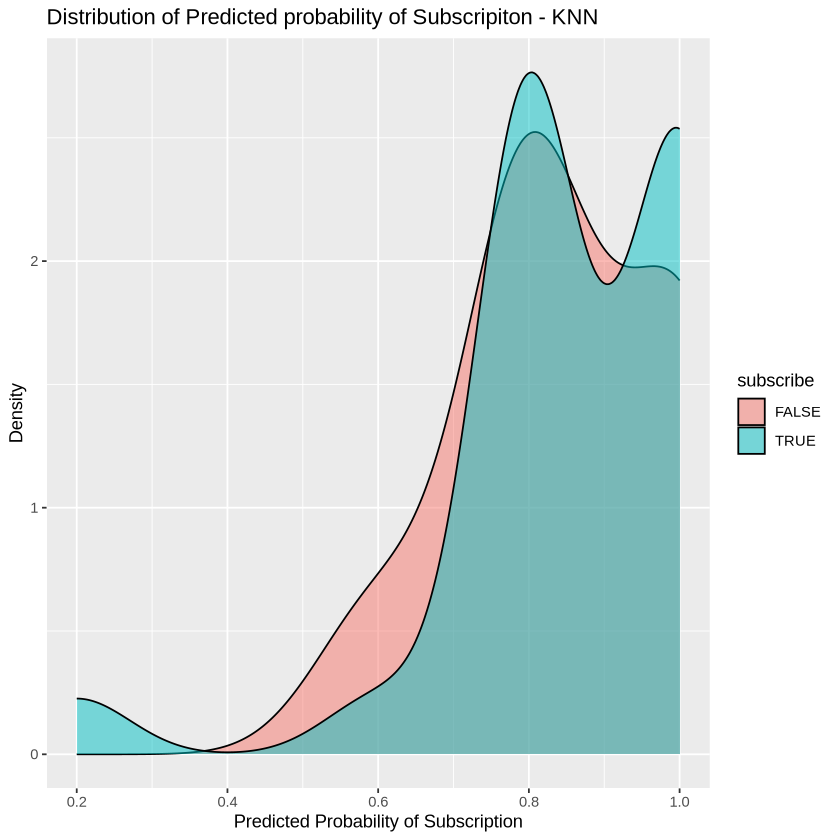

In [29]:
# Predict probabilities for KNN
newspaper_predictions2 <- predict(newspaper_AH_fit, player_testing, type = "prob") |>
    bind_cols(player_testing)

ppd_dist_KNN<-ggplot(newspaper_predictions2, aes(x = .pred_TRUE, fill = subscribe)) +
    geom_density(alpha = 0.5) +
    ggtitle("Distribution of Predicted probability of Subscripiton - KNN")+
    labs(x = "Predicted Probability of Subscription", y = "Density")
ppd_dist_KNN


**Figure 6.1** Plot visualizes the density vs probability of subscriptions, true or false, from the KNN model. Areas with overlap indicate that at some probability,  the model assigns similar probabilities to both classes, making it difficult to distinguish them. This plot shows significant overlap, which makes sense for our predicted accuracy of 65.7%

# 4.2 Data Analysis - Part 2: Logistic Regression Model
In part 4.2, a logistic regression model is used to predict the subscription status of each player in the testing data.

We chose Logistic Regression over other classification methods because our outcome variable, subscribe, is a logical (binary) variable with only two options, which are True or False. Since we cannot predict a continuous number for a logical variable, we cannot use linear and KNN regression methods that calculate the distance from a line. Instead, we use Logistic Regression to calculate the probability (likelihood) that a specific observation belongs to the 'True' category.

Unlike the classification we have been doing in the course so far, we can not output TRUE/FALSE directly, as there is no guarantee that our classification is rarely 100% certain. Instead, there is a certainty of each observation to be classified right. In one case, we are 51% confident that this person belongs to the TRUE category. In another case, we are 90% confident that this person belongs to the TRUE category. In the classification that we have been doing so far, we don’t take into account how confident our classification is, which can not be a good statistical measure.

### Methodology
Firstly, the model specification for the logistic regression model was set by the logistic_reg() function. Since we are eventually classifying the data using logistic regression, the classification mode was used in specification. 

Then the workflow was built by using the specification of logistic regression model and recipe with Age and Hours predictors, which was found to yield the prediction with the highest accuracy in KNN classification model from part 4.1. 

Subsequently, the workflow was passed to fit the training data into the model and train the logistic regression model.  

After fitting the model, the predict() function was used to actually predict the testing data using the trained logistic regression model. 

Then, the column of predictions was attached to the original data frame containing true subscription status. Using this, a confusion matrix that quantifies the number of true positive predictions out of all predictions was built using a conf_mat() function to determine the accuracy of the logistic regression model. Then, the metrics that indicate the accuracy and kappa value of the model was built by a metrics() function. 

In [28]:
# 1. Define the model specification
log_spec <- logistic_reg() |> 
  set_engine("glm") |> 
  set_mode("classification")

# 2. Build the workflow
probability_workflow <- workflow() |> 
  add_model(log_spec) |> 
  add_recipe(newspaper_AH_recipe)

# 3. Fit the model to the training data & Evaluate on the test set
probability_fit <- probability_workflow |> 
  fit(data = player_training)

# We predict both the class (.pred_class) and the probabilities (.pred_TRUE)
news_AH_predictions <- predict(probability_fit, player_testing) |> 
  bind_cols(predict(probability_fit, player_testing, type = "prob")) |> 
  bind_cols(player_testing)
# news_AH_predictions

# 4. Performance Metrics for Class Prediction
# Confusion Matrix
simple_conf_mat <- conf_mat(news_AH_predictions, truth = subscribe, estimate = .pred_class)
simple_conf_mat

# Accuracy
simple_metrics <- metrics(news_AH_predictions, truth = subscribe, estimate = .pred_class)
simple_metrics

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      8   25

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7575758
kap,binary,0.0000000


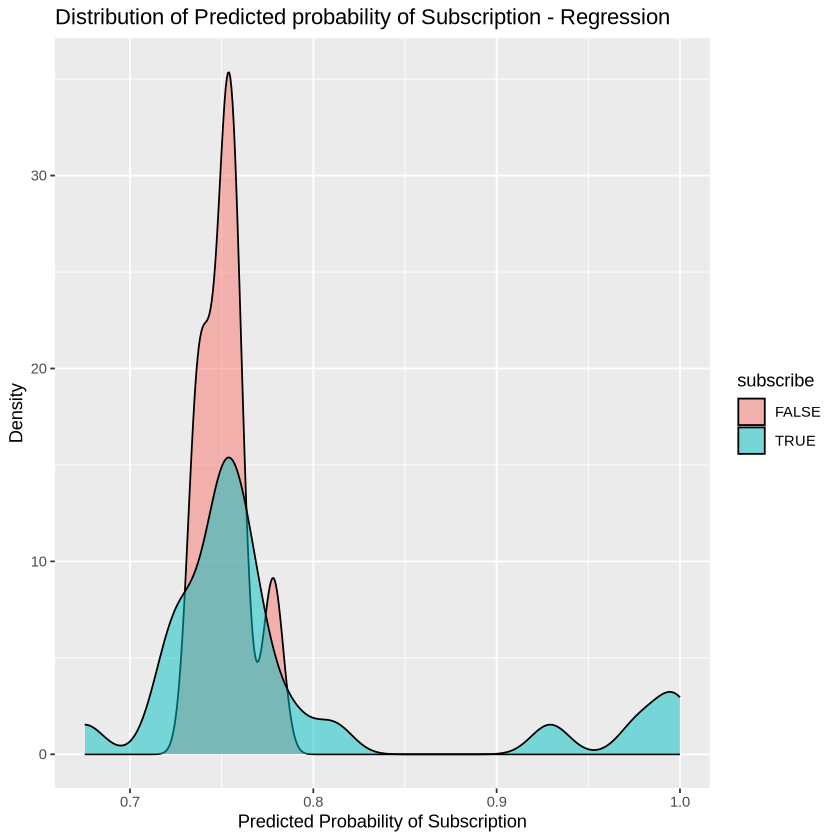

In [22]:
ppd_dist_R<-ggplot(news_AH_predictions, aes(x = .pred_TRUE, fill = subscribe)) +
    geom_density(alpha = 0.5) +
    ggtitle("Distribution of Predicted probability of Subscription - Regression")+
    labs(x = "Predicted Probability of Subscription", y = "Density")
ppd_dist_R

**Figure 7.** Plot visualizes the density vs probability of subscriptions for our Regression model, having less overlap, showing an improved accuracy of 73.7%

# 5. Discussion
**Conclusion**  
Our results show that played hours and age are meaningful predictors of subscription behaviour. Logistic regression produced the strongest predictive performance, with an accuracy of 75.8% compared to 72.7% for KNN Classification. This indicates that logistic regression generalizes better on this dataset and provides more stable probability estimates. This answers our research question by identifying both the most important predictors and the most effective model for estimating subscription probability.

**Predictor Expectations and Analysis**  
At the beginning of the project, the group hypothesized that the experience and/or played hours variables would be better predictors of subscription status than the age variable.  The initial reasoning was that individuals who are experienced or put more effort into the game must be more passionate and therefore more inclined to subscribe. However, after analysis of accuracy in each predictor, it was discovered that age and played hours were most consequential, suggesting that certain ages that resulted in x amount of hours played would be an area for further investigation. 

**Model Expectations and Analysis**  
For the model, it was predicted that logistic regression would be a better model than KNN. The difference in model performance was as expected. Logistic regression achieves higher accuracy because the dataset is imbalanced, so the model ends up predicting all cases as TRUE. Although this means it fails to identify any non-subscribers, it performs well on the majority group of subscribers. KNN, which relies on local neighbourhoods, incorrectly predicts some TRUE cases as false and is more affected by noise and imbalance, resulting in lower accuracy overall. For this reason, logistic regression is chosen as the better-performing model in this context, though its inability to detect the minority class remains a limitation.

Although the classification model has a precision of 75% and a recall of 96%, these metrics only reflect performance on the positive class. When examining the confusion matrix, it is seen that no true negatives are correctly predicted. Every time a player is not subscribed, they are predicted as being subscribed. However, some players who are suscribed are predicted to not subscribe. The logistic regression model gives a precision of 75.8% and a recall of 100%. This is because the model predicts everything as true, thereby correctly identifying all true subscribers but failing to correctly identify any non-subscribers.

Although logistic regression performed better, both models showed low Cohen's kappa values, signalling weak agreement. A kappa value of 0 is given by the logistic regression model, meaning that the agreement between the model’s classifications and true values are, in essence, random. The kNN classification model has a kappa below 0, meaning that the model is even worse at classifying than if classification would have been done with random guessing. This reflects the limited predictive power of the current dataset. Subscription behaviour likely depends on additional factors not captured here, such as game progression, social interactions, or exposure to subscription promotions. The dataset's moderate class imbalance and small size also restrict model accuracy.

**Impact**  
Despite these limitations, our findings support the idea that played hours and age are the strongest behavioural indicators of subscription. This is useful for identifying potential subscribers and understanding the engagement patterns that lead to more subscribers.

**Outlook**  
Future work could expand the dataset with more behavioural features (e.g. sessions per week, time of day activity patterns, retention metrics) or evaluate other models (e.g. decision trees, random forests, gradient boosting) not covered in DSCI 100. Collecting longitudinal data would enable modelling how subscription likelihood changes over time. Finally, demographic variables could be examined in combination with engagement metrics to explore whether certain age groups or other categories are more likely to subscribe. This would help identify which potential players are important to target for subscriptions. 

Overall, logistic regression provides a more accurate and interpretable approach for predicting subscription, and the analysis confirms that hours played and age are key parameters for predicting subscription likelihood.